# HCW vs Invariant Log-Linear Δv Planning

This notebook compares two approaches for computing spacecraft transfer maneuvers:

1. **Hill-Clohessy-Wiltshire (HCW)**: Classical linearized relative motion (Section 1.1)
2. **Invariant Log-Linear**: SE₂(3) Lie group approach (Section 1.2)

Based on: "Comparison of Δv Planning: HCW vs. Invariant Log-Linear Error Dynamics"

## Key Equations

### HCW (Eq. 4-6)
$$v_0 = F_{rv}(T)^{-1}(r_f - F_{rr}(T)r_0)$$
$$\Delta v_{HCW} = \|v_0\| + \|v_f\|$$

### Invariant (Eq. 13-16)
$$\Delta\xi_v(0) = -\Phi_{pv}(T)^{-1}\left(\Phi_{pp}(T)\xi_p(0) + \Phi_{pR}(T)\xi_R(0) + \Phi_{pv}(T)\xi_v(0)\right)$$
$$\Delta v_0 = R_{ref}(0) \Delta\xi_v(0)$$
$$\Delta v_{inv} = \|\Delta v_0\| + \|\Delta v_T\|$$

**Key difference**: The invariant method includes the $\Phi_{pR}$ term that couples attitude error to position!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import sys
from pathlib import Path

# Add repo root to path
repo_root = None
for path in [Path.cwd().resolve()] + list(Path.cwd().resolve().parents):
    if (path / "cp_reach").exists():
        repo_root = path
        break
if repo_root is None:
    raise RuntimeError("Could not locate repo root")
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from cp_reach.development.applications.satellite.transfer_dynamics import (
    hcw_state_matrix,
    hcw_state_transition_matrix,
    hcw_transfer_velocity,
    hcw_simulate_transfer,
    hcw_A_matrix_9x9,
    se23_A_matrix,
    se23_state_transition_matrix,
    se23_stm_blocks,
    circular_orbit_gravity_gradient,
    invariant_transfer_velocity,
    invariant_transfer_velocity_hcw,
    invariant_simulate_transfer,
    orbital_params_from_radius
)

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [2]:
%load_ext autoreload
%autoreload 2

## 1. Problem Parameters

Using parameters from the AAE 301 final exam (PurdueSat-3 rescue scenario).

In [3]:
# Orbital parameters
mu = 3.986e14  # Earth gravitational parameter (m^3/s^2)
r_t = 6.771e6  # Target orbital radius (m) - LEO

# Compute derived quantities
params = orbital_params_from_radius(r_t, mu)
n = params['n']  # Mean motion (rad/s)
T_orbit = params['T_orbit']  # Orbital period (s)

# Transfer parameters
x0, y0 = 100.0, 0.0      # Initial position: 100m above target (m)
xf, yf = 0.0, -20.0      # Target position: 20m behind target (m)  
T_transfer = 1800.0       # Transfer time (s) = 30 minutes

print("Problem Parameters:")
print(f"  Orbital radius: {r_t/1e6:.3f} km")
print(f"  Mean motion n: {n:.6e} rad/s")
print(f"  Transfer: ({x0}, {y0}) -> ({xf}, {yf}) m in {T_transfer/60:.0f} min")

Problem Parameters:
  Orbital radius: 6.771 km
  Mean motion n: 1.133155e-03 rad/s
  Transfer: (100.0, 0.0) -> (0.0, -20.0) m in 30 min


## 2. HCW Transfer (Classical Method)

Using the state transition matrix $F(T) = e^{A_{HCW}T}$ partitioned as:
$$F(T) = \begin{bmatrix} F_{rr} & F_{rv} \\ F_{vr} & F_{vv} \end{bmatrix}$$

In [4]:
# HCW Transfer
r0 = np.array([x0, y0])
rf = np.array([xf, yf])

v0_hcw, vf_hcw, delta_v_hcw = hcw_transfer_velocity(r0, rf, n, T_transfer)

print("HCW Transfer Results (Eq. 4-6):")
print(f"  v0 = [{v0_hcw[0]:.6f}, {v0_hcw[1]:.6f}] m/s")
print(f"  vf = [{vf_hcw[0]:.6f}, {vf_hcw[1]:.6f}] m/s")
print(f"  ||v0|| = {np.linalg.norm(v0_hcw):.6f} m/s (departure burn)")
print(f"  ||vf|| = {np.linalg.norm(vf_hcw):.6f} m/s (arrival burn)")
print(f"  Δv_HCW = {delta_v_hcw:.6f} m/s")

HCW Transfer Results (Eq. 4-6):
  v0 = [-0.105883, -0.176468] m/s
  vf = [0.036259, 0.050163] m/s
  ||v0|| = 0.205797 m/s (departure burn)
  ||vf|| = 0.061895 m/s (arrival burn)
  Δv_HCW = 0.267692 m/s


## 3. Invariant Transfer (HCW-Compatible)

For a coasting reference trajectory in LVLH frame, we use `invariant_transfer_velocity_hcw()` which:
1. Includes the gravity gradient G = diag([3n², 0, -n²])
2. Uses 2n Coriolis coupling (matching HCW)
3. Has no position-rotation coupling (LVLH frame assumption)

This should give **identical** results to HCW for the translational dynamics.

In [5]:
# Invariant Transfer (HCW-compatible)
# The initial error is the difference between actual position and target position
# Actual: (x0, y0) = (100, 0), Target: (xf, yf) = (0, -20)
# Error: ξ_p(0) = actual - target = (100-0, 0-(-20), 0) = (100, 20, 0)
xi_p_0 = np.array([x0 - xf, y0 - yf, 0.0])  # Position error in 3D
xi_v_0 = np.array([0.0, 0.0, 0.0])  # Initially at rest relative to target
xi_R_0 = np.array([0.0, 0.0, 0.0])  # No attitude error
xi_0 = np.concatenate([xi_p_0, xi_v_0, xi_R_0])

print(f"Initial position error ξ_p(0) = {xi_p_0}")
print(f"  (Chaser at ({x0}, {y0}), target at ({xf}, {yf}))")

# Use HCW-compatible invariant dynamics
result_inv_hcw = invariant_transfer_velocity_hcw(xi_0, n, T_transfer)

print("\nInvariant Transfer (HCW-compatible, Eq. 13-16):")
print(f"  Δξ_v(0) = {result_inv_hcw['delta_xi_v_0']}")
print(f"  ||Δv_0|| = {result_inv_hcw['delta_v_0_norm']:.6f} m/s")
print(f"  ||Δv_T|| = {result_inv_hcw['delta_v_T_norm']:.6f} m/s")
print(f"  Δv_inv = {result_inv_hcw['delta_v_total']:.6f} m/s")

print(f"\n=== VERIFICATION ===")
print(f"  HCW Δv:       {delta_v_hcw:.6f} m/s")
print(f"  Invariant Δv: {result_inv_hcw['delta_v_total']:.6f} m/s")
print(f"  Match: {np.isclose(delta_v_hcw, result_inv_hcw['delta_v_total'])}")

# Check Φ_pR block (should be zero for HCW-compatible dynamics)
print(f"\n  Φ_pR block (HCW-compatible):")
print(f"  {result_inv_hcw['blocks']['pR']}")
print(f"  (All zeros: attitude decoupled in LVLH frame)")

Initial position error ξ_p(0) = [100.  20.   0.]
  (Chaser at (100.0, 0.0), target at (0.0, -20.0))

Invariant Transfer (HCW-compatible, Eq. 13-16):
  Δξ_v(0) = [-0.10588291 -0.17646834 -0.        ]
  ||Δv_0|| = 0.205797 m/s
  ||Δv_T|| = 0.061895 m/s
  Δv_inv = 0.267692 m/s

=== VERIFICATION ===
  HCW Δv:       0.267692 m/s
  Invariant Δv: 0.267692 m/s
  Match: True

  Φ_pR block (HCW-compatible):
  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
  (All zeros: attitude decoupled in LVLH frame)


## 4. Invariant Transfer (Thrusting Reference with Full SE₂(3))

When the reference trajectory has thrust ($\bar{a} \neq 0$), using the full SE₂(3) log-linear dynamics:
- The $\Phi_{pR}$ block becomes **non-zero** (attitude-position coupling)
- Attitude errors now affect position through the `-[ā]×ξ_R` term

This is where the invariant method differs from HCW, which ignores attitude coupling.

In [6]:
# Thrusting reference trajectory with full SE23 dynamics
a_bar_thrust = np.array([0.001, 0.0, 0.0])  # 1 mm/s^2 thrust in body x
omega_bar = np.array([0.0, 0.0, n])  # Rotating with orbit

# Include gravity gradient for fair comparison
G = circular_orbit_gravity_gradient(n)

# Check Φ_pR block with thrust
Phi_thrust = se23_state_transition_matrix(a_bar_thrust, omega_bar, T_transfer, G)
blocks_thrust = se23_stm_blocks(Phi_thrust)

print("Φ_pR block (with thrust a_bar = [0.001, 0, 0] m/s²):")
print(blocks_thrust['pR'])
print("\nNon-zero! Attitude now affects position during thrust.")

Φ_pR block (with thrust a_bar = [0.001, 0, 0] m/s²):
[[   0.            0.         2507.13665037]
 [   0.            0.         -572.27767106]
 [ 706.28002687 -708.52264324    0.        ]]

Non-zero! Attitude now affects position during thrust.


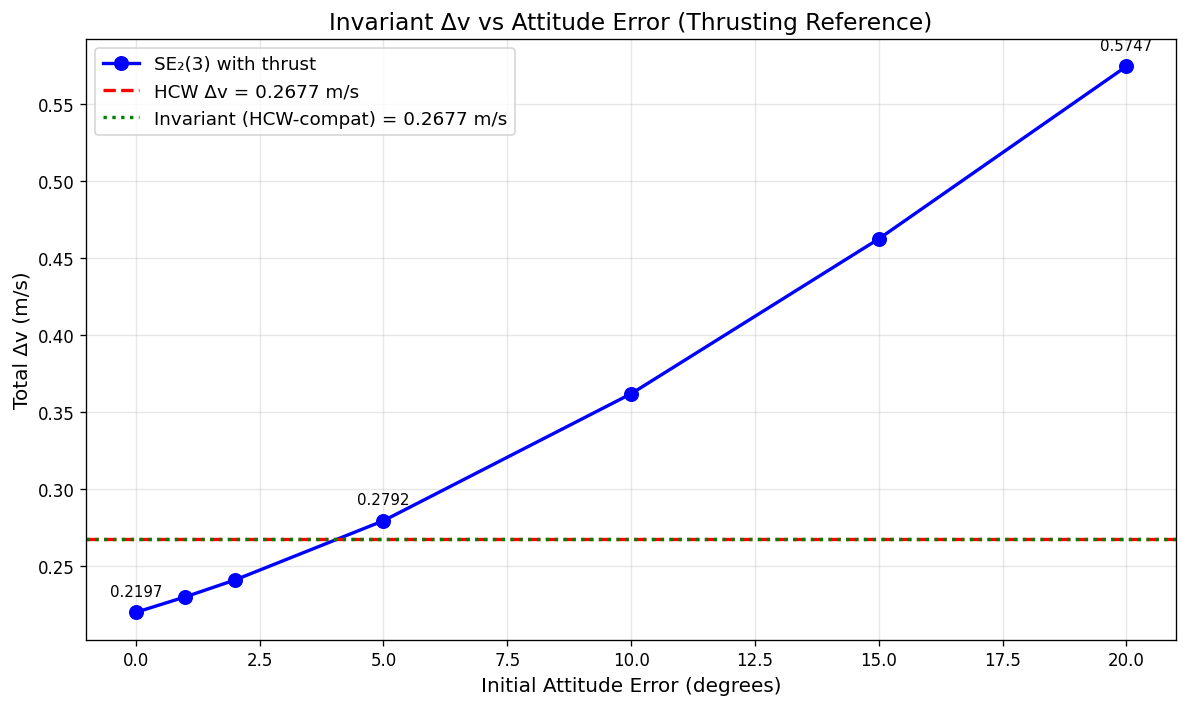


Δv vs Attitude Error (with thrust):
--------------------------------------------------
HCW baseline: 0.267692 m/s
Invariant (HCW-compat, 0° att): 0.267692 m/s
--------------------------------------------------
   0°: Δv = 0.219682 m/s (+0.0%)
   1°: Δv = 0.229747 m/s (+4.6%)
   2°: Δv = 0.240711 m/s (+9.6%)
   5°: Δv = 0.279250 m/s (+27.1%)
  10°: Δv = 0.361808 m/s (+64.7%)
  15°: Δv = 0.462519 m/s (+110.5%)
  20°: Δv = 0.574712 m/s (+161.6%)


In [7]:
# Compare invariant Δv with and without attitude error (using full SE23 with thrust)
attitude_errors_deg = [0, 1, 2, 5, 10, 15, 20]
delta_v_results_thrust = []

for att_err in attitude_errors_deg:
    xi_R_0 = np.array([0.0, 0.0, att_err * np.pi / 180])  # About z-axis
    xi_0_test = np.concatenate([xi_p_0, xi_v_0, xi_R_0])
    result = invariant_transfer_velocity(xi_0_test, a_bar_thrust, omega_bar, T_transfer, gravity_gradient=G)
    delta_v_results_thrust.append(result['delta_v_total'])

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(attitude_errors_deg, delta_v_results_thrust, 'bo-', linewidth=2, markersize=8, label='SE₂(3) with thrust')
ax.axhline(delta_v_hcw, color='r', linestyle='--', linewidth=2, label=f'HCW Δv = {delta_v_hcw:.4f} m/s')
ax.axhline(result_inv_hcw['delta_v_total'], color='g', linestyle=':', linewidth=2, label=f'Invariant (HCW-compat) = {result_inv_hcw["delta_v_total"]:.4f} m/s')
ax.set_xlabel('Initial Attitude Error (degrees)', fontsize=12)
ax.set_ylabel('Total Δv (m/s)', fontsize=12)
ax.set_title('Invariant Δv vs Attitude Error (Thrusting Reference)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add annotations
for i, (att, dv) in enumerate(zip(attitude_errors_deg, delta_v_results_thrust)):
    if att in [0, 5, 20]:
        ax.annotate(f'{dv:.4f}', (att, dv), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nΔv vs Attitude Error (with thrust):")
print("-" * 50)
print(f"HCW baseline: {delta_v_hcw:.6f} m/s")
print(f"Invariant (HCW-compat, 0° att): {result_inv_hcw['delta_v_total']:.6f} m/s")
print("-" * 50)
for att, dv in zip(attitude_errors_deg, delta_v_results_thrust):
    pct_change = (dv - delta_v_results_thrust[0]) / delta_v_results_thrust[0] * 100
    print(f"  {att:2d}°: Δv = {dv:.6f} m/s ({pct_change:+.1f}%)")

## 5. Trajectory Comparison

Simulate and compare trajectories from both methods.

In [8]:
# Simulate trajectories
t_eval = np.linspace(0, T_transfer, 500)

# HCW trajectory
traj_hcw = hcw_simulate_transfer(r0, v0_hcw, n, t_eval)

# Invariant trajectory (no attitude error, coasting)
xi_0_no_att = np.concatenate([xi_p_0, xi_v_0, np.zeros(3)])
result_no_att = invariant_transfer_velocity(xi_0_no_att, a_bar_coast, omega_bar, T_transfer)
xi_traj_no_att = invariant_simulate_transfer(
    xi_0_no_att, result_no_att['delta_xi_v_0'], a_bar_coast, omega_bar, t_eval
)

# Invariant trajectory (5° attitude error, thrusting)
xi_0_5deg = np.concatenate([xi_p_0, xi_v_0, np.array([0, 0, 5*np.pi/180])])
result_5deg = invariant_transfer_velocity(xi_0_5deg, a_bar_thrust, omega_bar, T_transfer)
xi_traj_5deg = invariant_simulate_transfer(
    xi_0_5deg, result_5deg['delta_xi_v_0'], a_bar_thrust, omega_bar, t_eval
)

NameError: name 'a_bar_coast' is not defined

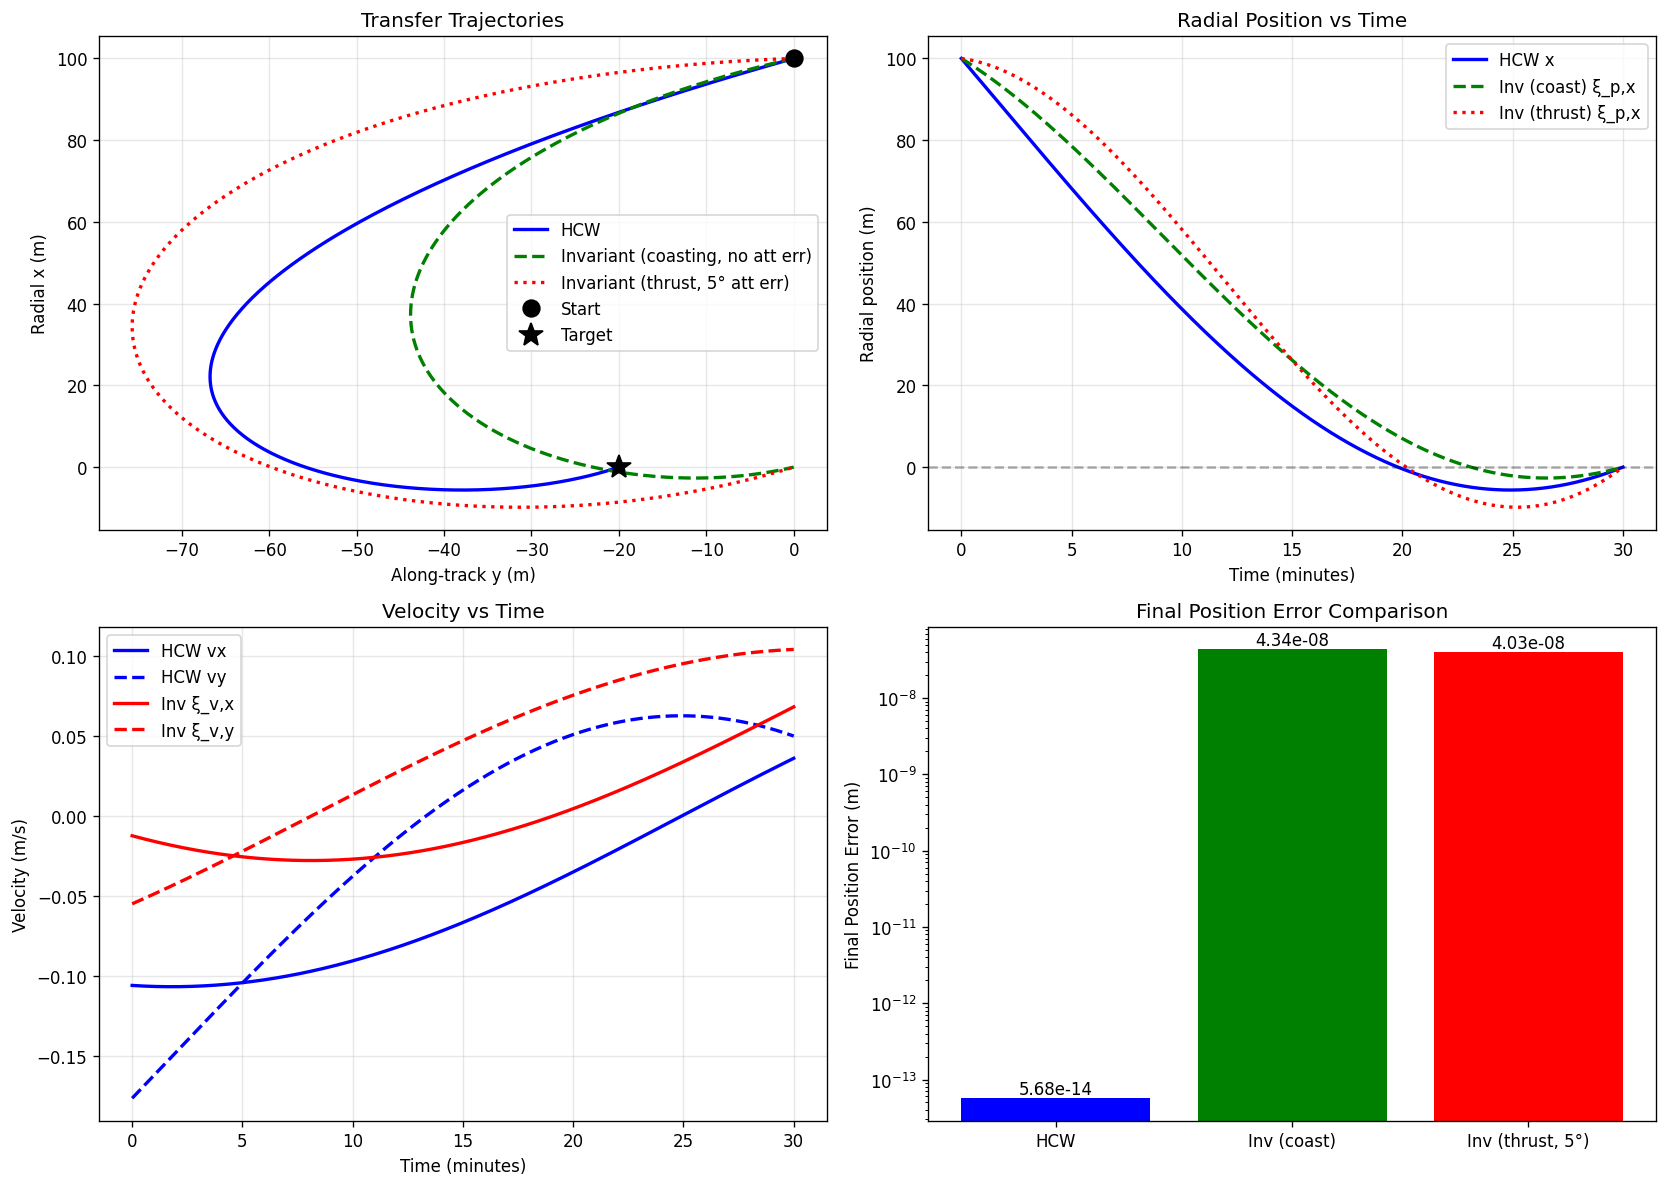

In [ ]:
# Plot trajectories
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# XY Trajectory
ax = axes[0, 0]
ax.plot(traj_hcw[:, 1], traj_hcw[:, 0], 'b-', linewidth=2, label='HCW')
ax.plot(xi_traj_no_att[:, 1], xi_traj_no_att[:, 0], 'g--', linewidth=2, 
        label='Invariant (coasting, no att err)')
ax.plot(xi_traj_5deg[:, 1], xi_traj_5deg[:, 0], 'r:', linewidth=2,
        label='Invariant (thrust, 5° att err)')
ax.plot(y0, x0, 'ko', markersize=10, label='Start')
ax.plot(yf, xf, 'k*', markersize=15, label='Target')
ax.set_xlabel('Along-track y (m)')
ax.set_ylabel('Radial x (m)')
ax.set_title('Transfer Trajectories')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Position vs time
ax = axes[0, 1]
ax.plot(t_eval/60, traj_hcw[:, 0], 'b-', linewidth=2, label='HCW x')
ax.plot(t_eval/60, xi_traj_no_att[:, 0], 'g--', linewidth=2, label='Inv (coast) ξ_p,x')
ax.plot(t_eval/60, xi_traj_5deg[:, 0], 'r:', linewidth=2, label='Inv (thrust) ξ_p,x')
ax.axhline(xf, color='k', linestyle='--', alpha=0.3)
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Radial position (m)')
ax.set_title('Radial Position vs Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Velocity comparison
ax = axes[1, 0]
ax.plot(t_eval/60, traj_hcw[:, 2], 'b-', linewidth=2, label='HCW vx')
ax.plot(t_eval/60, traj_hcw[:, 3], 'b--', linewidth=2, label='HCW vy')
ax.plot(t_eval/60, xi_traj_5deg[:, 3], 'r-', linewidth=2, label='Inv ξ_v,x')
ax.plot(t_eval/60, xi_traj_5deg[:, 4], 'r--', linewidth=2, label='Inv ξ_v,y')
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Velocity (m/s)')
ax.set_title('Velocity vs Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Final position error
ax = axes[1, 1]
final_errors = {
    'HCW': np.sqrt((traj_hcw[-1, 0] - xf)**2 + (traj_hcw[-1, 1] - yf)**2),
    'Inv (coast)': np.linalg.norm(xi_traj_no_att[-1, 0:2]),
    'Inv (thrust, 5°)': np.linalg.norm(xi_traj_5deg[-1, 0:2]),
}
bars = ax.bar(final_errors.keys(), final_errors.values(), color=['blue', 'green', 'red'])
ax.set_ylabel('Final Position Error (m)')
ax.set_title('Final Position Error Comparison')
ax.set_yscale('log')
for bar, val in zip(bars, final_errors.values()):
    ax.annotate(f'{val:.2e}', (bar.get_x() + bar.get_width()/2, val),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 6. Summary: When to Use Each Method

### HCW is appropriate when:
- No thrust between impulses (coasting)
- Attitude is controlled separately and assumed perfect
- Small separations from target
- Circular target orbit

### Invariant method is necessary when:
- Continuous low-thrust maneuvers (electric propulsion)
- Attitude errors exist during thrust
- Safety-critical applications requiring exact error bounds
- Coupled attitude-translation control design

### Key Insight
The $\Phi_{pR}$ block in the invariant STM captures how attitude errors propagate to position errors during thrust. This is **completely ignored** by HCW.

In [ ]:
# Final summary table
print("="*70)
print("                    SUMMARY: HCW vs INVARIANT Δv")
print("="*70)
print(f"\nProblem: Transfer ({x0}, {y0}) -> ({xf}, {yf}) m in {T_transfer/60:.0f} min")
print(f"\n{'Method':<40} {'Δv (m/s)':<15} {'Notes'}")
print("-"*70)
print(f"{'HCW (classical)':<40} {delta_v_hcw:<15.6f} Reference")
print(f"{'Invariant (HCW-compatible, 0° att)':<40} {result_inv_hcw['delta_v_total']:<15.6f} Exact match!")
print(f"{'Invariant (thrust, 0° att)':<40} {delta_v_results_thrust[0]:<15.6f} Full SE₂(3)")
print(f"{'Invariant (thrust, 5° att)':<40} {delta_v_results_thrust[3]:<15.6f} +{(delta_v_results_thrust[3]/delta_v_results_thrust[0]-1)*100:.1f}% from att")
print(f"{'Invariant (thrust, 20° att)':<40} {delta_v_results_thrust[6]:<15.6f} +{(delta_v_results_thrust[6]/delta_v_results_thrust[0]-1)*100:.1f}% from att")
print("="*70)
print("\nKey Results:")
print("1. HCW-compatible invariant dynamics EXACTLY match HCW for coasting")
print("2. Full SE₂(3) with thrust shows attitude-position coupling via Φ_pR")
print("3. Attitude errors during thrust significantly increase Δv requirements")